<a href="https://colab.research.google.com/github/pythagoras58/Quantizer/blob/main/SMPC_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U qiskit
!pip install qiskit-aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=0bad91cdea5c17c7ed0629103d1ecedac5e98aa9bd6b47d3d1d67dc17ab33a91
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [2]:
# Modify all count results
def print_final_result(result):
    print("Final Result (Formatted):\n")
    for binary_key, value in result.items():
        print(f"Binary sequence: {binary_key}, Frequency: {value}")

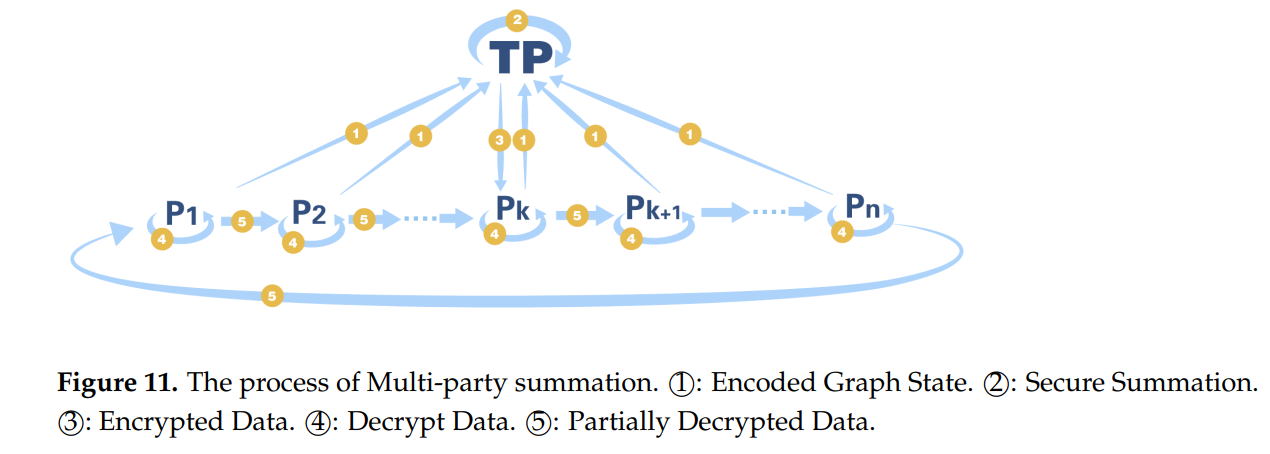

# Graph State Preparation
graph states can be created using a combination of Hadamard gates and Controlled-Z (CZ) gates. The participants in the protocol generate random keys Y_k and use these to determine how to prepare their qubits.

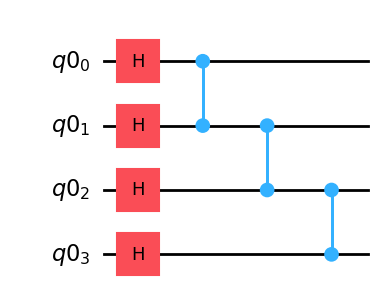

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, assemble
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

%matplotlib inline

# Create a quantum register for each participant
num_participants = 4  # Assume: 4 participants
qr = QuantumRegister(num_participants)

# Create a quantum circuit
qc = QuantumCircuit(qr)

# Apply Hadamard gate to each qubit to create superposition
for i in range(num_participants):
    qc.h(qr[i])

# Apply Controlled-Z (CZ) gates between qubits to entangle them
for i in range(num_participants - 1):
    qc.cz(qr[i], qr[i+1])

# The quantum circuit now represents a graph state
qc.draw('mpl')  # Draw the circuit
#circuit_drawer(qc)

# Data Encoding

Participants use their private keys X_k and Zk
  to encrypt the data by applying gates (X or Z) based on their random values. In Qiskit, X-gates and Z-gates are straightforward.

In [4]:
# Example: Random keys for each participant
import random
X_k = [random.choice([0, 1]) for _ in range(num_participants)]
Z_k = [random.choice([0, 1]) for _ in range(num_participants)]

# Apply X and Z gates according to the random keys
for i in range(num_participants):
    if X_k[i] == 1:
        qc.x(qr[i])
    if Z_k[i] == 1:
        qc.z(qr[i])


# Graph State Verification

After encoding, the Trusted Third Party (TP) measures stabilizers to verify the integrity of the graph state. In Qiskit, stabilizers can be measured by converting them to Pauli measurements (X, Y, or Z).

In [5]:
# Measure stabilizers (X, Y, or Z basis)
qc.measure_all()

# Execute the circuit using Qiskit simulator
from qiskit_aer import AerSimulator
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
#result = execute(transpiled_qc, simulator, shots=1024).result()
result = simulator.run(transpiled_qc, shots=1024).result()
counts = result.get_counts()
print(counts)


{'0100': 62, '0011': 60, '0111': 69, '1100': 61, '1011': 61, '0000': 57, '0010': 68, '1111': 62, '0001': 72, '1000': 70, '0110': 71, '1101': 53, '1001': 64, '0101': 73, '1110': 64, '1010': 57}


In [6]:
print_final_result(counts)

Final Result (Formatted):

Binary sequence: 0100, Frequency: 62
Binary sequence: 0011, Frequency: 60
Binary sequence: 0111, Frequency: 69
Binary sequence: 1100, Frequency: 61
Binary sequence: 1011, Frequency: 61
Binary sequence: 0000, Frequency: 57
Binary sequence: 0010, Frequency: 68
Binary sequence: 1111, Frequency: 62
Binary sequence: 0001, Frequency: 72
Binary sequence: 1000, Frequency: 70
Binary sequence: 0110, Frequency: 71
Binary sequence: 1101, Frequency: 53
Binary sequence: 1001, Frequency: 64
Binary sequence: 0101, Frequency: 73
Binary sequence: 1110, Frequency: 64
Binary sequence: 1010, Frequency: 57


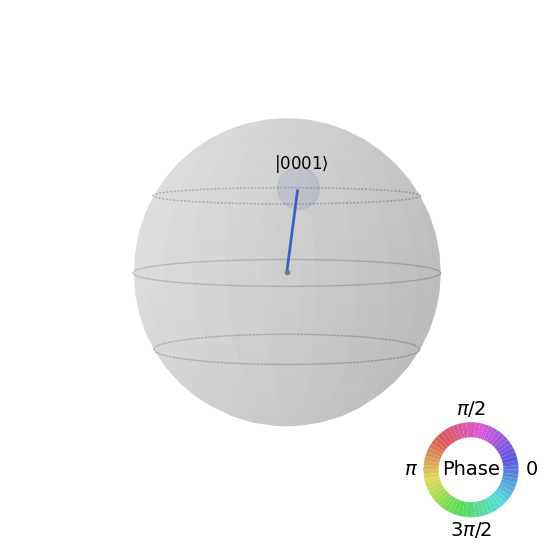

In [7]:
# visualize the graph state
from qiskit.visualization import plot_state_qsphere
from qiskit_aer import Aer


_simulator = Aer.get_backend('statevector_simulator')
_result_qc = transpile(qc, _simulator)
_fin_res = _simulator.run(_result_qc).result()
statevector = _fin_res.get_statevector()
#plot_state_qsphere(statevector)
statevector.draw('qsphere')
# plt.show()
# plot_state_qsphere(statevector)

# **Resending on Failure:**
If the stabilizer measurements do not match, the protocol would either terminate or request a resend. This logic can be handled in Python code after the circuit is executed.
# **Measurement for Summation:**
Once the graph state is verified, each participant performs a final measurement based on their key
  (X-basis or Y-basis), and the final sum
D is calculated. In Qiskit, this involves applying appropriate basis rotations before measurement.

In [8]:
# Example: Final measurements based on y_k
Y_k = [random.choice([0, 1]) for _ in range(num_participants)]

for i in range(num_participants):
    if Y_k[i] == 0:
        qc.h(qr[i])  # X-basis measurement
    else:
        qc.sdg(qr[i])  # Y-basis measurement
        qc.h(qr[i])


In [9]:
# Measure final qubits
qc.measure_all()

# Execute and retrieve the final sum
transpiled_qc = transpile(qc, simulator)
#result = execute(transpiled_qc, simulator, shots=1024).result()
result = simulator.run(transpiled_qc, shots=1024).result()
counts = result.get_counts()
print("Final result:", counts)

Final result: {'1001 0111': 4, '0011 1010': 1, '1100 1111': 2, '0010 0111': 1, '0111 1010': 2, '1010 0011': 5, '1110 1111': 1, '1001 0100': 6, '0100 0010': 4, '0110 0001': 1, '1010 0110': 1, '0000 0101': 1, '1000 1111': 3, '0111 1111': 2, '1110 1010': 3, '1101 1110': 3, '0000 1110': 3, '1000 0000': 4, '1110 1101': 2, '0101 1110': 4, '1101 1111': 4, '0010 0011': 4, '0111 0101': 3, '0110 0111': 2, '1100 1000': 4, '0101 1100': 2, '1010 1001': 4, '0110 0110': 1, '1110 1000': 6, '1011 1111': 2, '1001 0001': 7, '0000 0011': 1, '1000 0110': 3, '1111 1001': 3, '1100 1011': 3, '1100 0010': 5, '0111 1101': 3, '0000 1001': 2, '0110 0000': 7, '1000 0100': 4, '0011 0111': 1, '0010 1010': 4, '0000 1010': 5, '1010 1111': 4, '0110 0010': 3, '1100 1100': 5, '1110 0001': 2, '0010 0101': 4, '0111 1110': 5, '1001 1110': 1, '1000 1100': 3, '1111 1101': 2, '1100 0101': 1, '1100 0001': 6, '1100 1101': 6, '1101 1010': 3, '0100 1101': 3, '0100 1001': 6, '0000 0000': 5, '1101 0101': 3, '0001 1111': 2, '0001 011

In [10]:
print_final_result(counts)


Final Result (Formatted):

Binary sequence: 1001 0111, Frequency: 4
Binary sequence: 0011 1010, Frequency: 1
Binary sequence: 1100 1111, Frequency: 2
Binary sequence: 0010 0111, Frequency: 1
Binary sequence: 0111 1010, Frequency: 2
Binary sequence: 1010 0011, Frequency: 5
Binary sequence: 1110 1111, Frequency: 1
Binary sequence: 1001 0100, Frequency: 6
Binary sequence: 0100 0010, Frequency: 4
Binary sequence: 0110 0001, Frequency: 1
Binary sequence: 1010 0110, Frequency: 1
Binary sequence: 0000 0101, Frequency: 1
Binary sequence: 1000 1111, Frequency: 3
Binary sequence: 0111 1111, Frequency: 2
Binary sequence: 1110 1010, Frequency: 3
Binary sequence: 1101 1110, Frequency: 3
Binary sequence: 0000 1110, Frequency: 3
Binary sequence: 1000 0000, Frequency: 4
Binary sequence: 1110 1101, Frequency: 2
Binary sequence: 0101 1110, Frequency: 4
Binary sequence: 1101 1111, Frequency: 4
Binary sequence: 0010 0011, Frequency: 4
Binary sequence: 0111 0101, Frequency: 3
Binary sequence: 0110 0111, Fr

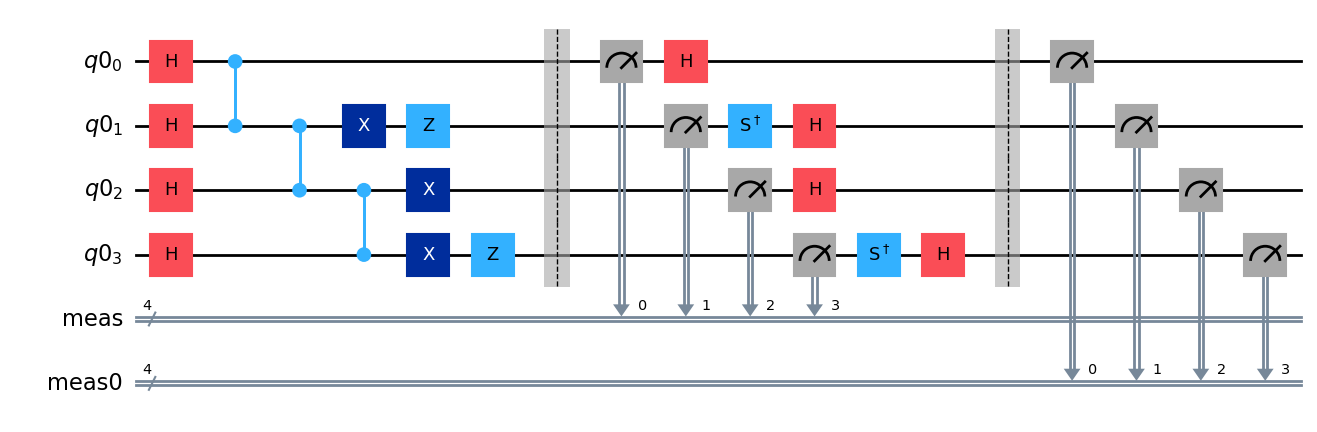

In [11]:
qc.draw('mpl')

In [12]:
# check the frequency mapping for the counts
binary_sequence = list(counts.keys())
binary_sequence.sort()
print(binary_sequence)

['0000 0000', '0000 0001', '0000 0010', '0000 0011', '0000 0100', '0000 0101', '0000 0110', '0000 0111', '0000 1000', '0000 1001', '0000 1010', '0000 1011', '0000 1100', '0000 1101', '0000 1110', '0000 1111', '0001 0000', '0001 0001', '0001 0010', '0001 0011', '0001 0100', '0001 0101', '0001 0110', '0001 0111', '0001 1000', '0001 1001', '0001 1010', '0001 1011', '0001 1100', '0001 1101', '0001 1110', '0001 1111', '0010 0000', '0010 0001', '0010 0011', '0010 0100', '0010 0101', '0010 0110', '0010 0111', '0010 1000', '0010 1001', '0010 1010', '0010 1011', '0010 1100', '0010 1101', '0010 1110', '0010 1111', '0011 0000', '0011 0001', '0011 0010', '0011 0011', '0011 0100', '0011 0101', '0011 0110', '0011 0111', '0011 1000', '0011 1001', '0011 1010', '0011 1011', '0011 1100', '0011 1101', '0011 1110', '0011 1111', '0100 0000', '0100 0001', '0100 0010', '0100 0011', '0100 0100', '0100 0101', '0100 0110', '0100 0111', '0100 1000', '0100 1001', '0100 1010', '0100 1011', '0100 1100', '0100 1101'

Text(0.5, 1.0, 'Frequency Mapping of Binary Sequences')

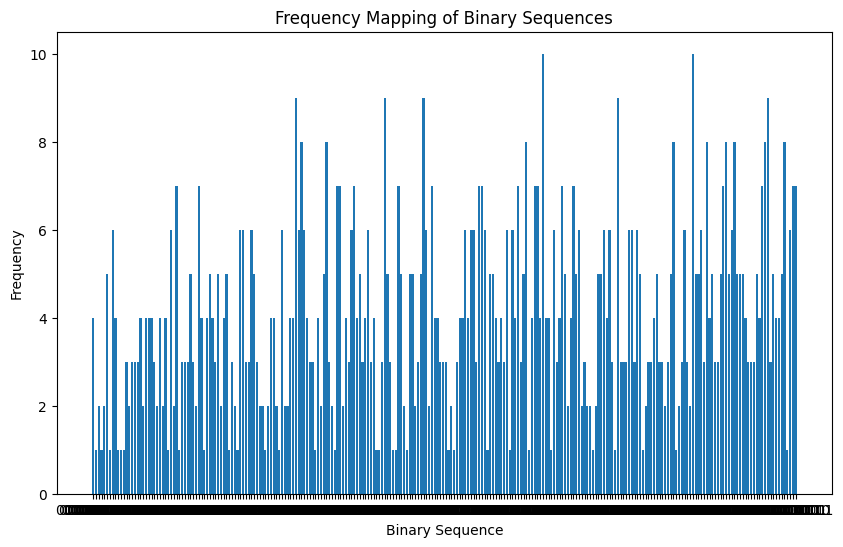

In [13]:
frequencies = list(counts.values())

plt.figure(figsize=(10, 6))
plt.bar(binary_sequence, frequencies)
plt.xlabel('Binary Sequence')
plt.ylabel('Frequency')
plt.title('Frequency Mapping of Binary Sequences')

The decryption phase

Steps:
Initialize the secret data and decryption keys: You'll need the secret string
D and the decryption keys X'_K

Participants' decryption process: Each participant applies the XOR operation between their decryption key and the previously decrypted data.

Final result: The last participant announces the final summation result
f(T1, T2, ..., Tn)

In [16]:
import numpy as np

# Secret data D (as a bitstring or integer)
D = int('10101010', 2)  # Assume: 8-bit binary string '10101010' as D

# List of decryption keys X'_k for each participant (as integers or bitstrings)
decryption_keys = [int('11001100', 2), int('10101010', 2), int('11110000', 2)]

# Number of participants
n = len(decryption_keys)

# Decryption process: participant Pk decrypts the data
# F1 = D ⊕ X'_k
def decrypt_data(D, keys):
    F = D  # Initial data D
    for k in range(n):
        # XOR operation between F and the decryption key X'_k
        F = F ^ keys[k]
        print(f'Participant {k+1} decrypted data: {bin(F)[2:]}')  # Show binary result
    return F

# Final decryption result
final_result = decrypt_data(D, decryption_keys)

# Final output
print(f'Final summation result: {bin(final_result)[2:]}')

Participant 1 decrypted data: 1100110
Participant 2 decrypted data: 11001100
Participant 3 decrypted data: 111100
Final summation result: 111100
